# A quick introduction to PyClaw
PyClaw is a solver for hyperbolic PDEs, based on [Clawpack](www.clawpack.org).  You can read more about PyClaw in [this paper](http://epubs.siam.org/doi/abs/10.1137/110856976) (free version [here](http://arxiv.org/abs/1111.6583).  

In this notebook, we explore some basic PyClaw functionality.  Before running the notebook, you should [install Clawpack](http://clawpack.github.io/doc/installing.html).  The quick way is to just

    pip install clawpack
    
If you are viewing this notebook online, you can download it and run it [from here](https://github.com/clawpack/doc/blob/master/doc/pyclaw/intro_notebook.ipynb).

In [2]:
%matplotlib inline
import matplotlib
from clawpack import pyclaw
from clawpack import riemann

Populating the interactive namespace from numpy and matplotlib


## Setting up a problem
To solve a problem, we'll need to create the following:

- A controller, which handles the running, output, and can be used for plotting (you don't absolutely need a controller, but it makes life simpler)
- A solver, which is responsible for actually evolving the solution in time.  Here we'll need to specify the equations to be solved and the boundary conditions.
- A domain over which to solve the problem
- A solution, where we will provide the initial data.  After running, the solution will contain -- you guessed it! -- the solution.

Let's start by creating a controller and specifying the simulation end time:

In [3]:
claw = pyclaw.Controller()
claw.tfinal = 1.0

claw.keep_copy = True       # Keep solution data in memory for plotting
claw.output_format = None   # Don't write solution data to file
claw.num_output_times = 50  # Write 50 output frames

## Riemann solvers

Like many solvers for nonlinear hyperbolic PDEs, PyClaw uses Riemann solvers.  By specifying a Riemann solver, we will specify the system of PDEs that we want to solve.

Place your cursor at the end of the line in the box below and hit 'Tab' (for autocompletion).  You'll see a dropdown list of all the Riemann solvers currently available in PyClaw.  The ones with 'py' at the end of the name are written in pure Python; the others are Fortran, wrapped with f2py.

Note that this won't work if you're viewing the notebook online as HTML; you need to actually be running it.

In [ ]:
riemann.

We'll solve the one-dimensional acoustics equations:
$$\begin{align}
p_t + K u_x & = 0 \\
u_t + \frac{1}{\rho} p_x & = 0.
\end{align}$$
Here $p, u$ are the pressure and velocity as functions of $x,t$, while $\rho, K$ are constants representing the density and bulk modulus of the material transmitting the waves.  We'll specify these constants later.

We can do this using the first solver in the list.  Notice that the solver we create here belongs to the controller that we created above.

In [4]:
riemann_solver = riemann.acoustics_1D
claw.solver = pyclaw.ClawSolver1D(riemann_solver)

We also need to specify boundary conditions.  We'll use periodic BCs, so that waves that go off one side of the domain come back in at the other:

In [5]:
claw.solver.all_bcs = pyclaw.BC.periodic

## The problem domain
Next we need to specify the domain and the grid.  We'll solve on the unit line $[0,1]$ using 100 grid cells.  Note that each argument to the Domain constructor must be a tuple:

In [6]:
domain = pyclaw.Domain( (0.,), (1.,), (100,))

## The initial solution
Next we create a solution object that belongs to the controller and extends over the domain we specified:

In [7]:
claw.solution = pyclaw.Solution(claw.solver.num_eqn,domain)

The initial data is specified in an array named $q$.  The pressure is contained in `q[0,:]` and the velocity in `q[1,:]`.  We'll specify a wavepacket for the pressure and zero velocity.

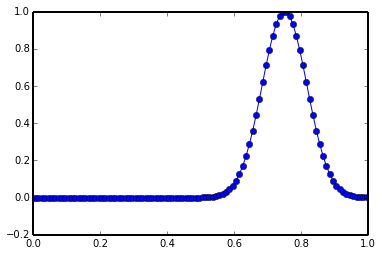

In [9]:
x=domain.grid.x.centers
bet=100; gam=5; x0=0.75
claw.solution.q[0,:] = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))
claw.solution.q[1,:] = 0.

plt.plot(x, claw.solution.q[0,:],'-o')

## Problem-specific parameters
The Riemann solver we've chosen requires some physical parameters to be specified.  Press 'Tab' in the box below and you'll see what they are.

In [ ]:
riemann_solver.cparam.

Two of these parameters are $\rho$ and $K$ in the equations above.  The other two are the impedance $Z = \sqrt{\rho K}$ and sound speed $c = \sqrt{K/\rho}$.  We specify these parameters in a dictionary that belongs to the solution object:

In [10]:
import numpy as np

density = 1.0
bulk_modulus = 1.0
impedance = np.sqrt(density*bulk_modulus)
sound_speed = np.sqrt(density/bulk_modulus)

claw.solution.state.problem_data = {
                              'rho' : density,
                              'bulk': bulk_modulus,
                              'zz'  : np.sqrt(density*bulk_modulus),
                              'cc'  : np.sqrt(bulk_modulus/density)
                              }

Finally, let's run the simulation.

In [11]:
status = claw.run()

2014-01-09 14:50:12,569 INFO CLAW: Solution 0 computed for time t=0.000000
2014-01-09 14:50:12,572 INFO CLAW: Solution 1 computed for time t=0.020000
2014-01-09 14:50:12,574 INFO CLAW: Solution 2 computed for time t=0.040000
2014-01-09 14:50:12,576 INFO CLAW: Solution 3 computed for time t=0.060000
2014-01-09 14:50:12,578 INFO CLAW: Solution 4 computed for time t=0.080000
2014-01-09 14:50:12,579 INFO CLAW: Solution 5 computed for time t=0.100000
2014-01-09 14:50:12,581 INFO CLAW: Solution 6 computed for time t=0.120000
2014-01-09 14:50:12,583 INFO CLAW: Solution 7 computed for time t=0.140000
2014-01-09 14:50:12,585 INFO CLAW: Solution 8 computed for time t=0.160000
2014-01-09 14:50:12,587 INFO CLAW: Solution 9 computed for time t=0.180000
2014-01-09 14:50:12,589 INFO CLAW: Solution 10 computed for time t=0.200000
2014-01-09 14:50:12,591 INFO CLAW: Solution 11 computed for time t=0.220000
2014-01-09 14:50:12,593 INFO CLAW: Solution 12 computed for time t=0.240000
2014-01-09 14:50:12,59

## Plotting
Now we'll plot the results, which are contained in `claw.frames[:]`.  It's simple to plot a single frame with matplotlib:

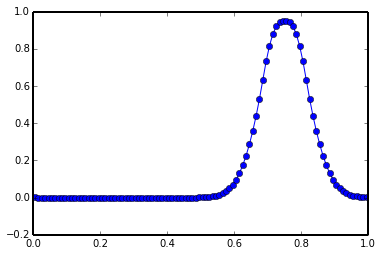

In [12]:
pressure = claw.frames[50].q[0,:]
plt.plot(x,pressure,'-o')

To examine the evolution more thoroughly, it's nice to see all the frames in sequence.  We can do this as follows.

In [13]:
from matplotlib import animation
import matplotlib.pyplot as plt
from clawpack.visclaw.JSAnimation import IPython_display
import numpy as np

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.2, 1.2))

frame = claw.frames[0]
pressure = frame.q[0,:]
line, = ax.plot([], [], lw=2)

def fplot(frame_number):
    frame = claw.frames[frame_number]
    pressure = frame.q[0,:]
    line.set_data(x,pressure)
    return line,

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=30)

That's it!  Here are some things you might try for fun:

- Change the boundary conditions to reflecting or outflow (hint: type `pyclaw.BC.`+[Tab] to get a list of boundary conditions available).
- Change the grid to use a larger or smaller number of grid cells.  How does this affect the final solution?
- Use higher-order methods by instantiating a `SharpClawSolver1D` instead of a `ClawSolver1D`.  How does this affect the final solution?  You can read more about the methods in SharpClaw in [this paper](http://epubs.siam.org/doi/abs/10.1137/110830320).